In [1]:
import pandas as pd

spotify_data = pd.read_csv("data/code_music.csv").drop(["Unnamed: 0","duration_ms","key"],axis=1)

In [2]:
num_data = spotify_data.drop(["track_name","artist_name"],axis=1)

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler

def remove_outliers(df):

  for col in num_data.columns:
    q3, q1 = np.percentile(num_data[col], [75,25])
    df.loc[(df[col]>q1) | (df[col]<q3)]     

    return df

num_data = remove_outliers(num_data)

standard_df = num_data.copy()

standardize = StandardScaler()
standard_df = standardize.fit_transform(standard_df)

standard_df = pd.DataFrame(standard_df,columns=num_data.columns)
standard_df.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity
0,-0.919845,1.078269,0.134659,-0.543676,0.011722,-0.582970,-0.375246,-0.431263,0.782276,-0.404695
1,1.256062,1.093787,1.168515,0.143192,-0.079547,0.462678,-0.862769,2.144042,-0.073951,1.591947
2,0.722812,-0.364871,-0.024047,-0.543676,0.568460,0.623811,-0.556770,-0.124487,0.030329,0.026025
3,0.250855,-0.897644,0.283446,-0.360511,0.796631,-1.779465,-0.530838,-0.957626,-0.282890,-1.719946
4,-0.576603,0.674811,1.249285,-0.433239,-0.931279,0.616954,-0.357958,-1.016963,-0.106585,-0.593654


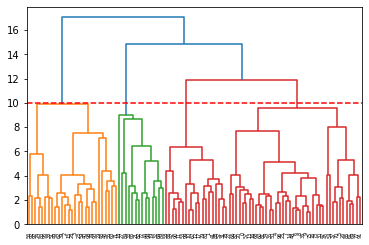

In [6]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

hierarchy.dendrogram(hierarchy.linkage(standard_df,method="ward"))
plt.axhline(y=10, color='r', linestyle='--')

In [8]:
from sklearn.cluster import AgglomerativeClustering

cluster_model = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward', distance_threshold=11)
clusters = cluster_model.fit_predict(standard_df)

standard_df["cluster"] = pd.DataFrame(clusters)
standard_df.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,cluster
0,-0.919845,1.078269,0.134659,-0.543676,0.011722,-0.582970,-0.375246,-0.431263,0.782276,-0.404695,1
1,1.256062,1.093787,1.168515,0.143192,-0.079547,0.462678,-0.862769,2.144042,-0.073951,1.591947,3
2,0.722812,-0.364871,-0.024047,-0.543676,0.568460,0.623811,-0.556770,-0.124487,0.030329,0.026025,0
3,0.250855,-0.897644,0.283446,-0.360511,0.796631,-1.779465,-0.530838,-0.957626,-0.282890,-1.719946,0
4,-0.576603,0.674811,1.249285,-0.433239,-0.931279,0.616954,-0.357958,-1.016963,-0.106585,-0.593654,1


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

X = standard_df.drop("cluster",axis=1)
y = standard_df.cluster

rf = RandomForestClassifier()
rf_model = rf.fit(X,y)

feat = pd.Series(rf_model.feature_importances_.round(3),list(X)).sort_values(ascending=False).head(12)
feat_df = pd.DataFrame(feat,columns=['Feature importance'])
feat_df

,Feature importance
acousticness,0.274
instrumentalness,0.169
valence,0.149
energy,0.110
loudness,0.079
danceability,0.062
liveness,0.054
popularity,0.037
speechiness,0.034
tempo,0.032


In [10]:
from sklearn.inspection import permutation_importance
import plotly.express as px

perm_importance = permutation_importance(rf_model, X, y, scoring="neg_mean_squared_error")

sorted_index = perm_importance.importances_mean.argsort()

px.bar(x=X.columns[sorted_index], y=perm_importance.importances_mean[sorted_index], title="Permutation importance")

In [11]:
#valence, acousticness, energy, instrumentalness

for col in spotify_data[["valence","acousticness","energy","instrumentalness"]].columns:
  max_value = spotify_data.iloc[spotify_data[col].idxmax(),]
  min_value = spotify_data.iloc[spotify_data[col].idxmin(),]
  print(f"The track with the highest {col} is '{max_value['track_name']}' and the lowest is '{min_value['track_name']}'")

The track with the highest valence is 'Inspector Norse' and the lowest is 'Sweet Unrest'
The track with the highest acousticness is 'Inspire' and the lowest is 'Time Lapse'
The track with the highest energy is 'Your Quest is Over (Feat. Pongball)' and the lowest is 'Miss You'
The track with the highest instrumentalness is 'Happiness' and the lowest is 'Keep Close'


In [4]:
X_most_important = num_data[["energy","valence","acousticness","liveness"]]

In [5]:
from sklearn.cluster import KMeans

sc = StandardScaler()

X = X_most_important.copy()

sc.fit_transform(X)

X = pd.DataFrame(X, columns=X_most_important.columns)

cluster_model = KMeans(n_clusters=6)
clusters = cluster_model.fit_predict(X)
X["cluster"] = np.array(clusters)

In [ ]:
import pickle
with open('cluster_model.pickle', 'wb') as f:
    pickle.dump(cluster_model, f)

import pickle
with open('sc.pickle', 'wb') as f:
    pickle.dump(sc, f)

In [19]:
X["cluster"].value_counts()

5    25
2    23
4    20
1    14
3    12
0     6
Name: clusters, dtype: int64

In [24]:
all_data = pd.concat([spotify_data[["artist_name","track_name"]],X],axis=1)

In [32]:
from db import tracks, engine 

with engine.begin() as conn:
  all_data.to_sql('tracks', con=conn, if_exists='append', index=False)

2022-04-07 21:23:22,089 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-04-07 21:23:22,089 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("tracks")
2022-04-07 21:23:22,089 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-04-07 21:23:22,102 INFO sqlalchemy.engine.Engine INSERT INTO tracks (artist_name, track_name, energy, valence, acousticness, liveness, cluster) VALUES (?, ?, ?, ?, ?, ?, ?)
2022-04-07 21:23:22,102 INFO sqlalchemy.engine.Engine [generated in 0.00185s] (('Emeralds', 'Candy Shoppe', 0.817, 0.185, 0.31, 0.123, 3), ('Marcus Marr', 'The Music', 0.82, 0.823, 0.28, 0.0666, 2), ('Phoenix', 'Love Like a Sunset, Pt. I', 0.538, 0.261, 0.493, 0.102, 3), ('Phoenix', 'Love Like a Sunset, Pt. II', 0.435, 0.0546, 0.568, 0.105, 4), ('Kalax', 'Time Lapse', 0.739, 0.0399, 3.53e-05, 0.125, 1), ('Mark McGuire', 'The Instinct', 0.568, 0.539, 0.0174, 0.135, 2), ('LIGHTS OUT ASIA', 'Ghost Identifier', 0.509, 0.0679, 0.0258, 0.132, 5), ('Stumbleine', 'Cherry Blossom', 0.519, 0.152, 0.0